---
# Original size-response implementation

In [1]:
from linescanning import (
    prf,
    utils,
    plotting,
    simulate
)
import yaml
import pandas as pd
import os
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
opj = os.path.join

Reading design matrix from '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/prf/sub-003/ses-1/design_task-2R.mat'
Reading settings from '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/code/prf_analysis.yml'
Instantiate HRF with: [1, 4.6, 0] (fit=False)
Using constraint(s): ['tc', 'tc']
Reading settings from '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/prf/sub-003/ses-1/sub-003_ses-1_task-2R_model-norm_stage-iter_desc-prf_params.pkl' (safest option; overwrites other settings)
Inserting parameters from <class 'str'> as 'norm_iter' in <linescanning.prf.pRFmodelFitting object at 0x7f4021b71be0>


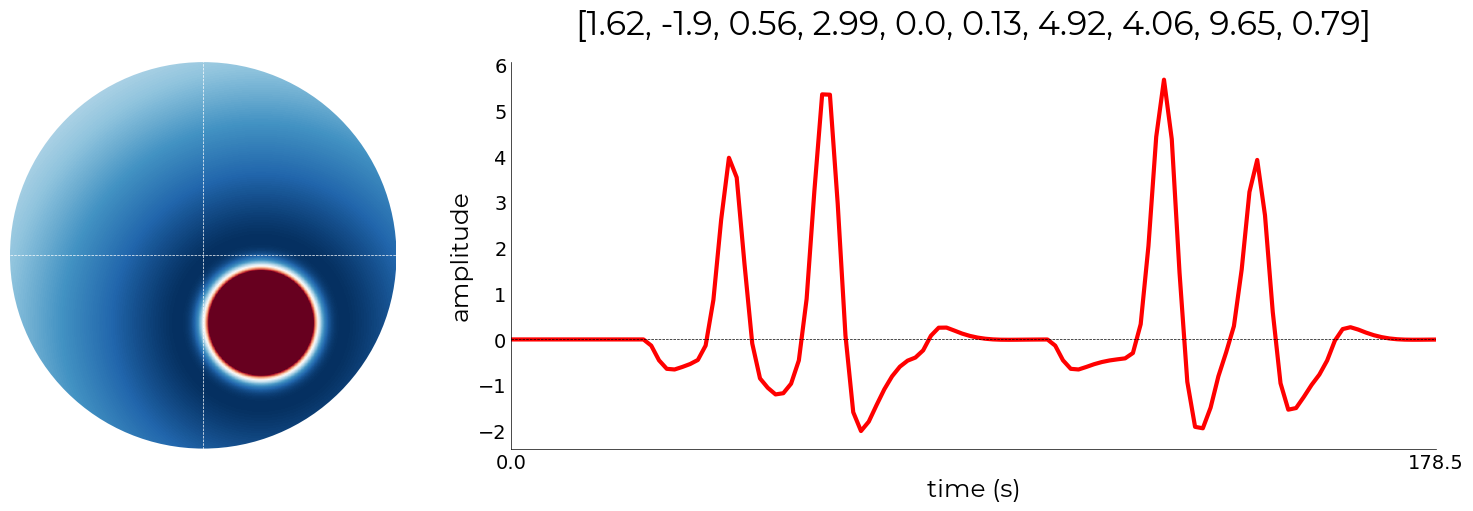

In [2]:
%matplotlib inline
subject = "sub-003"
proj_base = "/data1/projects/MicroFunc/Jurjen/projects"
proj_dir = opj(proj_base, "VE-SRF")

vert_file = opj(
    proj_dir,
    "derivatives",
    "pycortex",
    subject,
    f"{subject}_model-norm_desc-best_vertices.csv"
)

dm_file = opj(
    proj_dir,
    "derivatives",
    "prf",
    subject,
    "ses-1",
    "design_task-2R.mat"
)

vert_obj = utils.VertexInfo(vert_file, subject=subject)
target_ix = vert_obj.get("index")["lh"]

obj_ = prf.pRFmodelFitting(
    None,
    design_matrix=dm_file,
    TR=1.5,
    model="norm"
)

pars_file = opj(os.path.dirname(dm_file), f"{subject}_ses-1_task-2R_model-norm_stage-iter_desc-prf_params.pkl")
obj_.load_params(pars_file, model="norm")

pars,prf_,tc,pred = obj_.plot_vox(vox_nr=target_ix, model="norm", title="pars")

In [75]:
loc = [pars[0],pars[1]]
loc

[1.623233663401385, -1.8961574961751047]

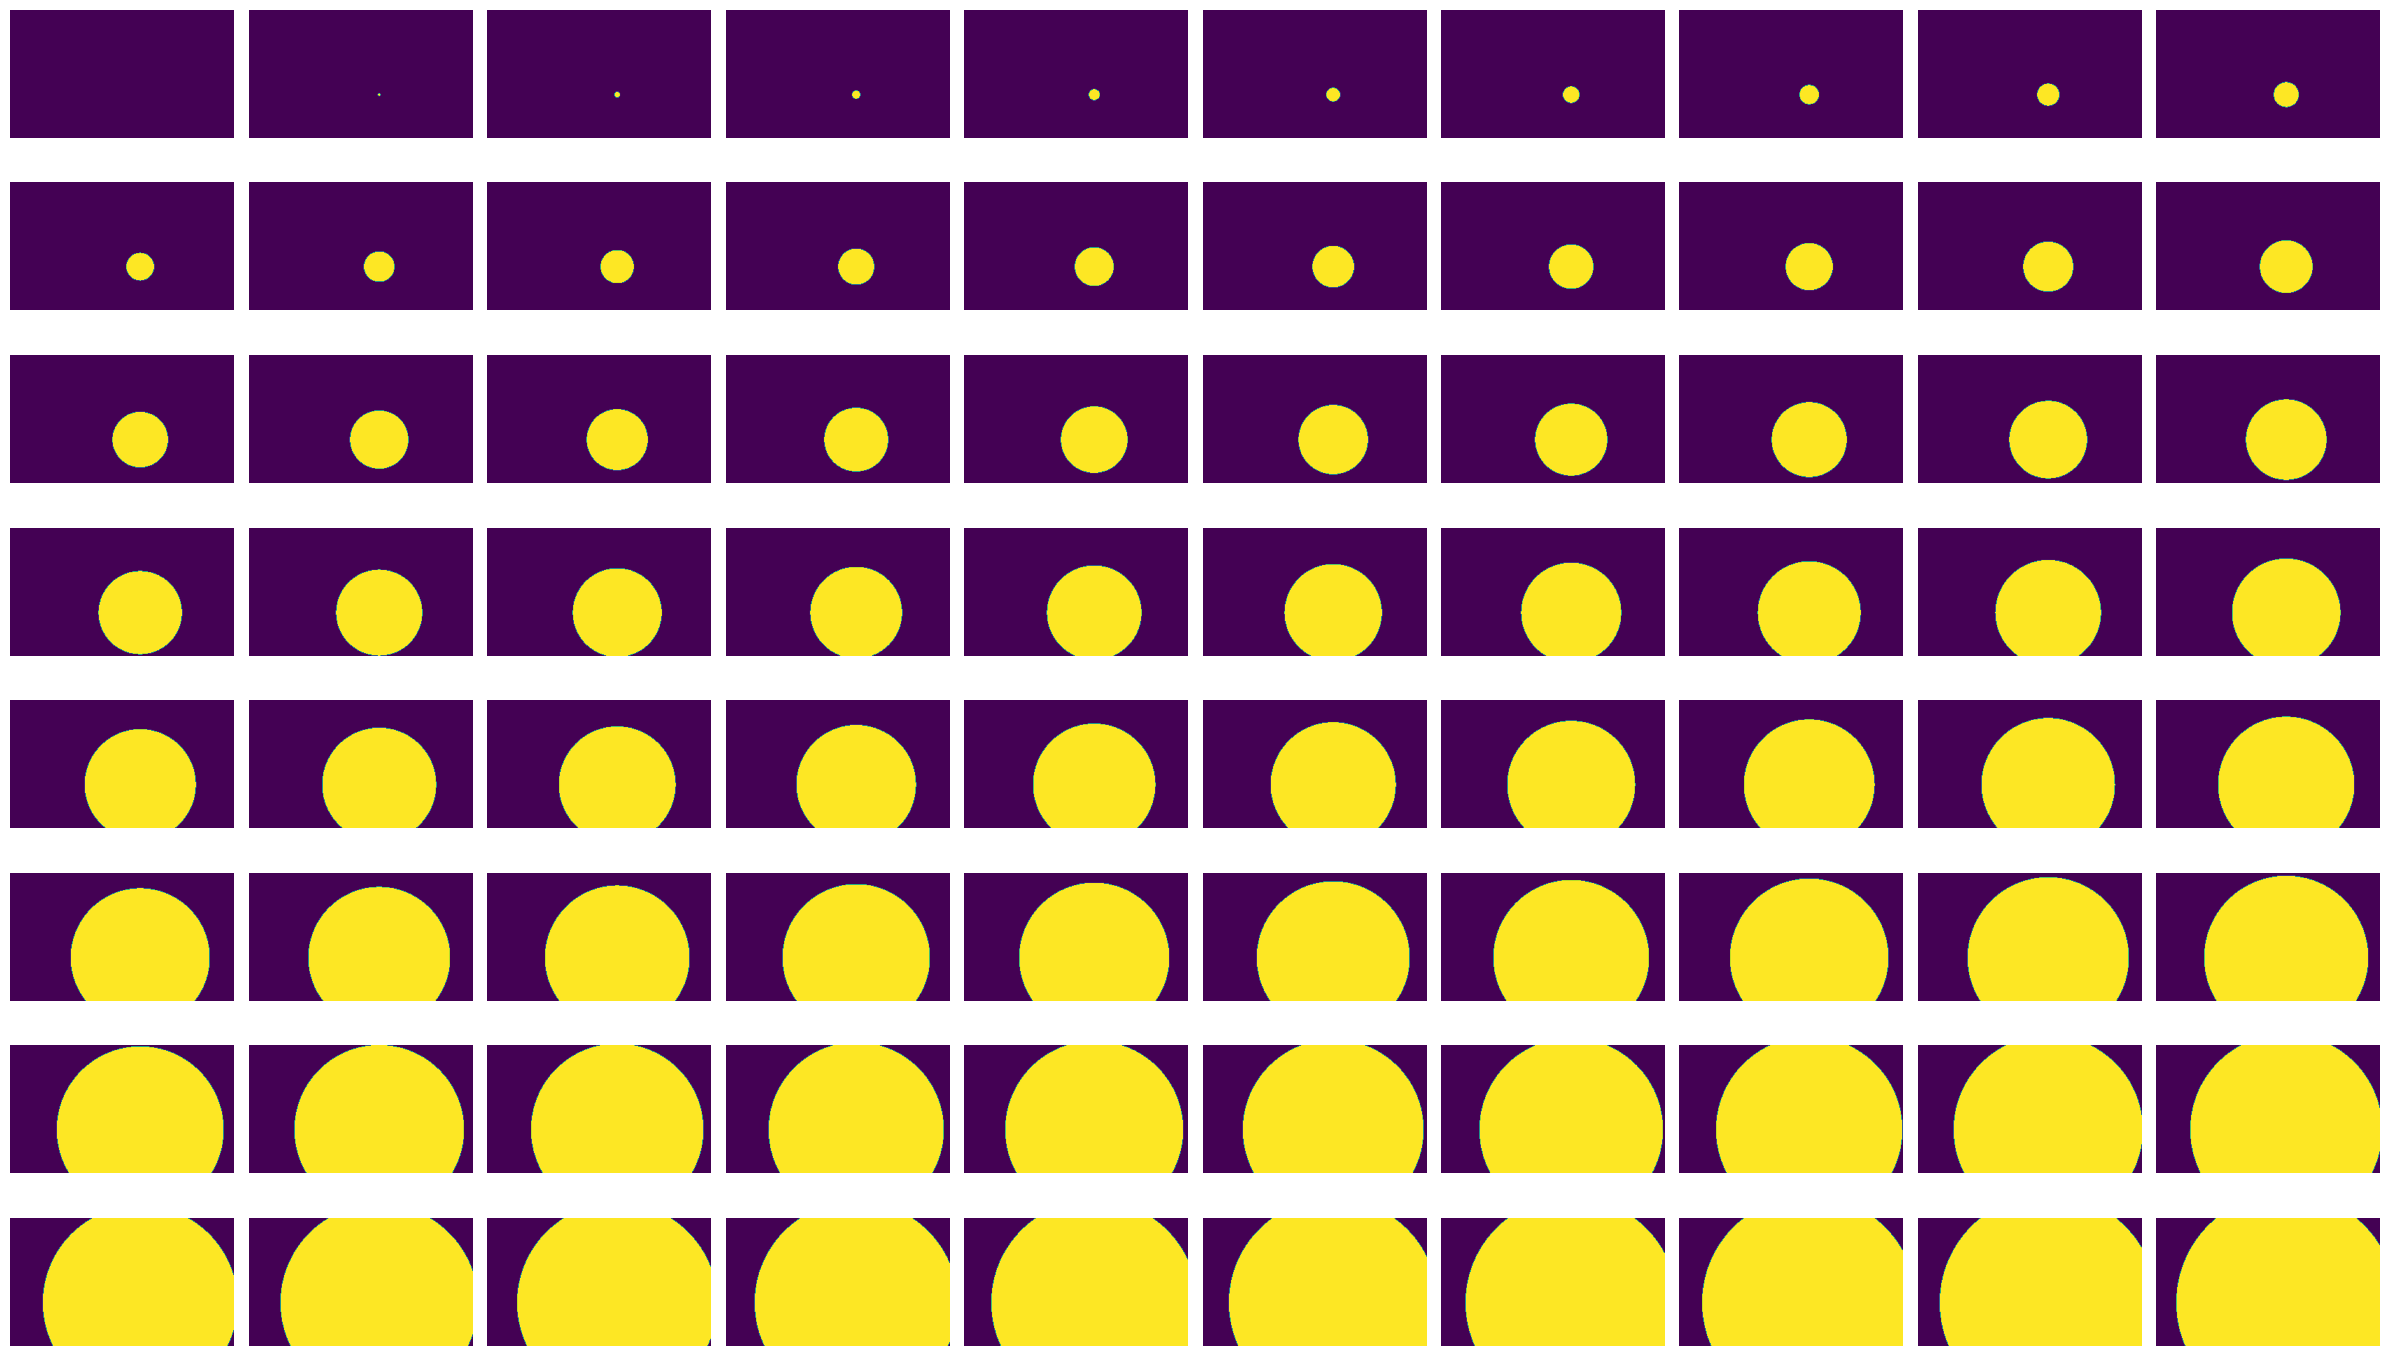

In [76]:
# get size-response functions
SR_ = prf.SizeResponse(prf_, pars, model="norm")
stims,sizes = SR_.make_stimuli(factor=1, loc=loc)
prf.plot_stims(stims, extent=SR_.vf_extent, interval=2, flipud=True)

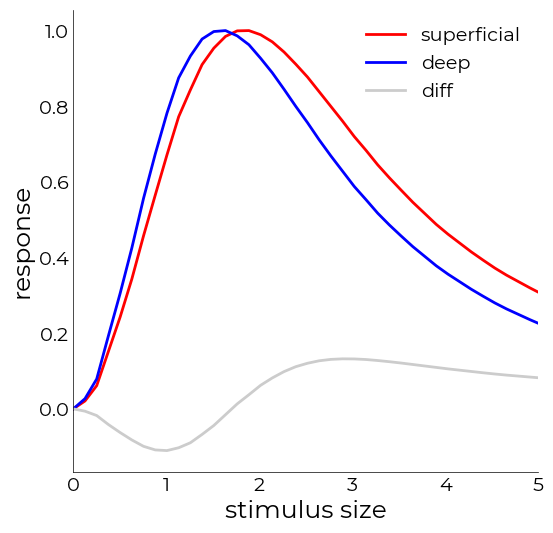

In [78]:
insert_pars = pars.copy()
# insert_pars[0] = insert_pars[1] = 0
srf_1 = SR_.make_sr_function(insert_pars, stims=stims, center_prf=False, normalize=True).squeeze()

pars_scaled = insert_pars.copy()
pars_scaled[2] *= 0.8
srf_2 = SR_.make_sr_function(pars_scaled, stims=stims, center_prf=False, normalize=True).squeeze()
diff = srf_1-srf_2
plotting.LazyPlot(
    [srf_1,srf_2,diff],
    xx=sizes,
    figsize=(6,6),
    line_width=2,
    color=["r","b","#cccccc"],
    labels=["superficial","deep","diff"],
    x_label="stimulus size",
    y_label="response",
    x_lim=[0,5]
)


In [79]:
use_stim_sizes = SR_.find_stim_sizes(srf_1,curve2=srf_2,sizes=sizes)
use_stim_sizes

[1.0071911511284228,
 1.3558191244535414,
 1.7044470977786599,
 2.300060828636438,
 2.895674559494216]

In [52]:
use_stim_sizes = SR_.find_stim_sizes(srf_1,curve2=srf_2,sizes=sizes)
use_stim_sizes

[1.0071911511284228,
 1.360515084805478,
 1.713839018482533,
 2.3047567889883744,
 2.895674559494216]

In [53]:
use_stim_sizes = [i/2 for i in use_stim_sizes]
use_stim_sizes

[0.5035955755642114,
 0.680257542402739,
 0.8569195092412665,
 1.1523783944941872,
 1.447837279747108]

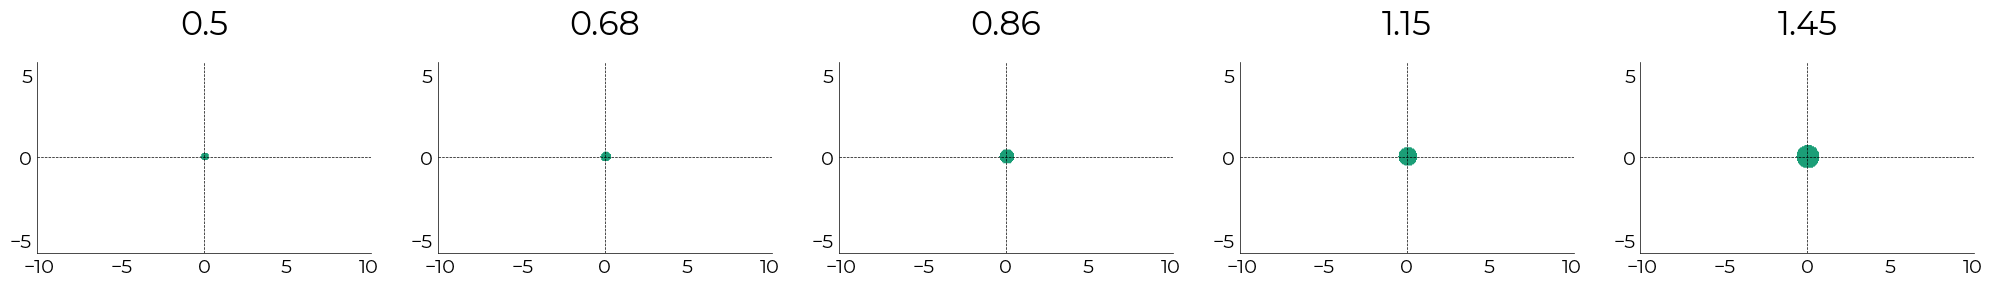

In [54]:
%matplotlib inline
# plot
cols = ["#1B9E77","#D95F02"]


fig,axs = plt.subplots(ncols=len(use_stim_sizes), figsize=(len(use_stim_sizes)*5,4))
selected_stims = []
for x,ss in enumerate(use_stim_sizes):
    
    # find corresponding stimulus given stimulus size
    ix = utils.find_nearest(sizes, ss)[0]
    img = stims[...,ix]

    SR_.plot_stim_size( 
        img, 
        ax=axs[x], 
        clip=False, 
        cmap=cols[0],
        vf_extent=SR_.vf_extent,
        axis=True)
    
    axs[x].set_title(f"{round(ss,2)}", fontsize=24)
    plotting.conform_ax_to_obj(axs[x], font_size=24)
    selected_stims.append(img)

    # axs.axis('off')

In [14]:
# settings
settings_path = "/data1/projects/MicroFunc/Jurjen/programs/project_repos/LineExps/sizeresponse/settings.yml"
with open(settings_path, 'r', encoding='utf8') as f_in:
    settings = yaml.safe_load(f_in)

TR = 0.105
events = [f"stim_{i+1}" for i in range(len(use_stim_sizes))]
n_events = len(use_stim_sizes)
stim_repetitions = settings['design'].get('stim_repetitions')
n_trials = int(n_events*stim_repetitions)

presented_stims = np.hstack([np.full(stim_repetitions, ii, dtype=int) for ii in range(n_events)])

# first optimize order
n_iters = 1

pkl_file = f"/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/data/{subject}_task-SRFa_desc-order.pkl"

# Selecting hemi-L parameters and set position to 0
insert_pars = pars.copy()
insert_pars[0] = insert_pars[1] = 0

if not os.path.exists(pkl_file):
    df_isis = []
    df_var = []
    orders = []

    results = Parallel(n_iters, verbose=False)(
        delayed(simulate.optimize_stimulus_order)(
            insert_pars,
            model="norm",
            TR=TR,
            tmin=settings['design'].get('minimal_iti_duration'),
            tmax=settings['design'].get('maximal_iti_duration'),
            tmean=settings['design'].get('mean_iti_duration'),
            n_trials=n_trials,
            leeway=settings['design'].get('total_iti_duration_leeway'),
            stim_duration=settings['design'].get('stim_duration'),
            total_duration=settings['design'].get('intended_duration'),
            start_duration=settings['design'].get('start_duration'),
            end_duration=settings['design'].get('end_duration'),
            verbose=True,
            events=events,
            order=presented_stims,
            stims=selected_stims
        ) for it in range(n_iters)
    )

# concatenate variance dataframe
df_var = pd.DataFrame(np.array([results[i][0] for i in range(n_iters)]), columns=["variance"])
df_var["it"] = np.arange(0,n_iters)
df_var["it"] = df_var["it"].astype(int)

# pull out list with used orders
order_list = [results[i][1] for i in range(n_iters)]

ITIs created with total ITI duration of 208.83s after 9 iterations
Total experiment time: 328.83s (= 3132 samples)


In [17]:
# get stim order for max variance
max_order = df_var.loc[df_var["variance"].idxmax()]
max_order_ix = max_order.it.astype(int)

print(f"Iteration {max_order_ix} maximizes variance for stimulus order (var = {round(max_order.variance,2)})")

# pull out list with used orders
obj_list = [results[i][1] for i in range(n_iters)]
order_list = [i.seq for i in obj_list]
final_order = order_list[max_order_ix]
final_order

Iteration 0 maximizes variance for stimulus order (var = 13.66)


array([4, 3, 3, 0, 2, 4, 4, 3, 2, 4, 1, 1, 0, 1, 2, 0, 3, 1, 0, 2, 2, 1,
       3, 0, 0, 3, 4, 2, 4, 1])

In [18]:
# first optimize order
n_iters = 1

pkl_file = f"/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/data/{subject}_task-SRFa_desc-itis.pkl"

# Selecting hemi-L parameters and set position to 0
insert_pars = pars.copy()
insert_pars[0] = insert_pars[1] = 0

if not os.path.exists(pkl_file):

    isi_results = Parallel(n_iters, verbose=False)(
        delayed(simulate.optimize_stimulus_isi)(
            insert_pars,
            model="norm",
            stims=selected_stims,
            TR=TR,
            tmin=settings['design'].get('minimal_iti_duration'),
            tmax=settings['design'].get('maximal_iti_duration'),
            tmean=settings['design'].get('mean_iti_duration'),
            n_trials=n_trials,
            leeway=settings['design'].get('total_iti_duration_leeway'),
            stim_duration=settings['design'].get('stim_duration'),
            total_duration=settings['design'].get('intended_duration'),
            start_duration=settings['design'].get('start_duration'),
            end_duration=settings['design'].get('end_duration'),
            verbose=False,
            events=events,
            seq=final_order # insert previously established order
        ) for it in range(n_iters)
    )

# concatenate variance dataframe
df_var_isi = pd.DataFrame(np.array([isi_results[i][0] for i in range(n_iters)]), columns=["variance"])
df_var_isi["it"] = np.arange(0,n_iters)
df_var_isi["it"] = df_var_isi["it"].astype(int)

# pull out list with used orders
obj_list = [isi_results[i][1] for i in range(n_iters)]

In [19]:
df_var_isi["obj"] = obj_list
df_var_isi

,variance,it,obj
0,13.999724,0,<linescanning.simulate.ITI object at 0x7f249b6...


In [20]:
obj_list[0].seq

array([4, 3, 3, 0, 2, 4, 4, 3, 2, 4, 1, 1, 0, 1, 2, 0, 3, 1, 0, 2, 2, 1,
       3, 0, 0, 3, 4, 2, 4, 1])

In [21]:
# get stim order for max variance
max_isi = df_var_isi.loc[df_var_isi["variance"].idxmax()]
max_isi_ix = max_order.it.astype(int)

print(f"Iteration {max_isi_ix} maximizes variance for ISIs (var = {round(max_isi.variance,2)})")
final_obj = obj_list[max_order_ix]
final_isis = final_obj.itis
final_isis

Iteration 0 maximizes variance for ISIs (var = 14.0)


array([ 5.45791102,  5.09980975,  8.57913799,  8.12512315,  6.25608689,
       11.31429128,  5.53772035,  5.586618  ,  5.2608399 , 10.72170849,
       11.27360928,  5.24117509,  6.93597648,  5.31930039,  8.53712309,
        5.10644389,  5.67011986,  5.85287457,  5.67028961, 11.95729918,
        5.00198269,  9.88126012,  7.05452792,  9.92218885,  7.9032525 ,
        5.63752506,  5.30947251,  5.95072937,  5.13236193,  5.26750902])

In [22]:
df_var_isi

,variance,it,obj
0,13.999724,0,<linescanning.simulate.ITI object at 0x7f249b6...


In [9]:
final_isis = np.loadtxt(f"/data1/projects/MicroFunc/Jurjen/programs/project_repos/LineExps/sizeresponse/data/{subject}/{subject}_task-SRFa_hemi-L_desc-itis.txt")
final_isis

array([ 5.18167393,  9.58212292,  5.95104792,  6.56856543,  6.55723777,
        8.1669329 ,  6.3088899 ,  6.69992734,  5.41365222,  7.23640208,
        8.9055057 ,  5.24422569,  5.81924547,  9.38793867,  6.24646251,
        5.8049505 ,  5.20928639,  7.34826541,  5.5877511 ,  5.72139898,
        5.11851937,  8.71255439,  6.67626643,  6.08971505,  5.83341468,
        7.29293341,  8.22948056,  5.01959248, 11.25502227, 11.62691934])

In [33]:
pkl_sims = f"/data1/projects/MicroFunc/Jurjen/programs/project_repos/LineExps/sizeresponse/data/{subject}/{subject}_desc-simulations.pkl"
import pickle
with open(pkl_sims, "rb") as handle:
    sims = pickle.load(handle)

In [50]:
final_obj = utils.select_from_df(sims["df_isi"], expression="hemi = lh").iloc[71].obj
final_obj.itis

array([ 5.18167393,  9.58212292,  5.95104792,  6.56856543,  6.55723777,
        8.1669329 ,  6.3088899 ,  6.69992734,  5.41365222,  7.23640208,
        8.9055057 ,  5.24422569,  5.81924547,  9.38793867,  6.24646251,
        5.8049505 ,  5.20928639,  7.34826541,  5.5877511 ,  5.72139898,
        5.11851937,  8.71255439,  6.67626643,  6.08971505,  5.83341468,
        7.29293341,  8.22948056,  5.01959248, 11.25502227, 11.62691934])

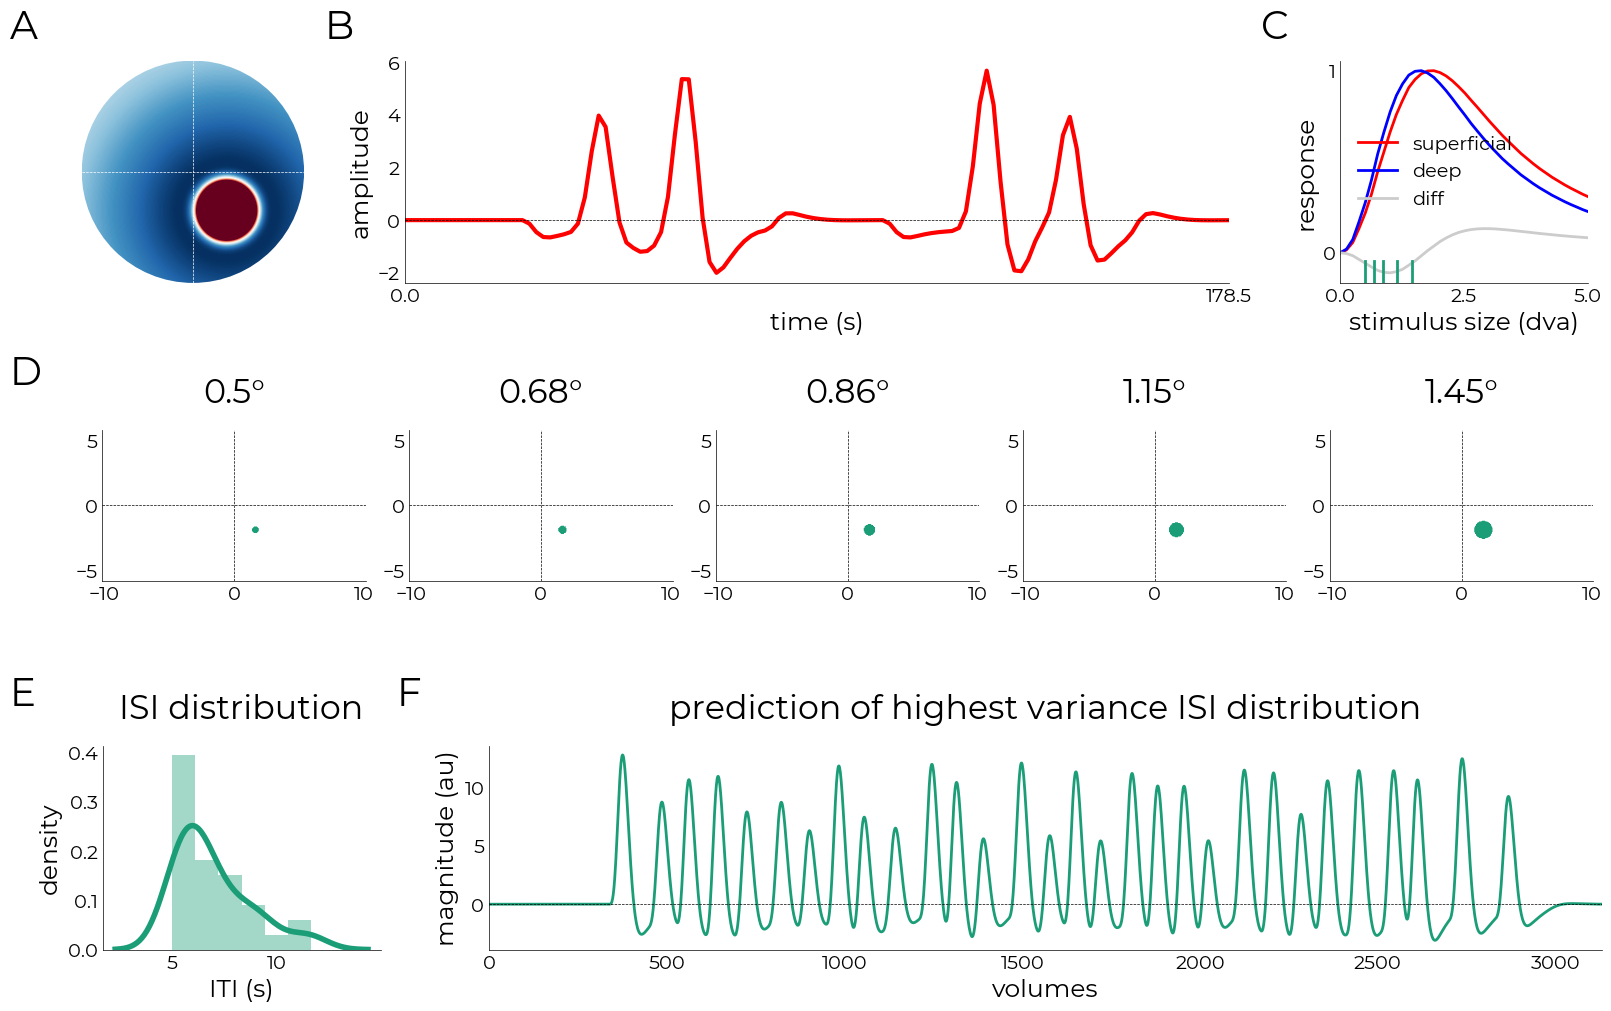

In [55]:
TR = 0.105

fig = plt.figure(figsize=(16,10), constrained_layout=True)
sf = fig.subfigures(nrows=3, hspace=0)
sf0 = sf[0].subplots(ncols=3, gridspec_kw={"width_ratios": [0.15,0.5,0.15], "wspace": 0})
sf1 = sf[1].subplots(ncols=len(use_stim_sizes))
sf2 = sf[2].subplots(ncols=2, gridspec_kw={"width_ratios": [0.2,0.8]})

# plot target prf and prediction
_ = obj_.plot_vox(
    vox_nr=target_ix, 
    axs=[sf0[0],sf0[1]],
    model="norm")

# plot SRFs
plotting.LazyPlot(
    [srf_1,srf_2,diff],
    xx=sizes,
    axs=sf0[-1],
    line_width=2,
    color=["r","b","#cccccc"],
    labels=["superficial","deep","diff"],
    x_label="stimulus size (dva)",
    y_label="response",
    x_lim=[0,5],
    y_ticks=[0,1],
    x_ticks=[0,2.5,5]
)

# plot distribution first so we can steal fontsizes from it
pl = plotting.LazyHist(
    final_isis,
    axs=sf2[0],
    kde=True,
    hist=True,
    fill=False,
    title="ISI distribution",
    y_label="density",
    x_label="ITI (s)",
    color="#1B9E77",
    hist_kwargs={"alpha": 0.4},
    kde_kwargs={"linewidth": 4}
)

# get localized stimulus representations
rf_stims,_ = SR_.make_stimuli(
    factor=1, 
    dt="fill", 
    loc=(pars[0],pars[1]))

cols = ["#1B9E77","#D95F02"]
for x,ss in enumerate(use_stim_sizes):
    
    sf0[-1].axvline(ss, color=cols[0], lw=2, ymax=0.1)

    # find corresponding stimulus given stimulus size
    ix = utils.find_nearest(sizes, ss)[0]
    img = rf_stims[...,ix]

    SR_.plot_stim_size( 
        img, 
        ax=sf1[x], 
        clip=False, 
        cmap=cols[0],
        vf_extent=SR_.vf_extent,
        axis=True)
    
    plotting.conform_ax_to_obj(sf1[x], title=f"{round(ss,2)}°", font_size=pl.label_size)

# get prediction given optimized ISIs
tc_def = simulate.prediction_from_obj(
    insert_pars,
    final_obj,
    stims=selected_stims,
    TR=TR,
    model="norm")

plotting.LazyPlot(
    tc_def,
    axs=sf2[1],
    line_width=2,
    add_hline=0,
    color="#1B9E77",
    y_label="magnitude (au)",
    title="prediction of highest variance ISI distribution",
    x_label="volumes")


plotting.fig_annot(
    fig,
    axs=list(sf0)+[sf1[0],sf2[0],sf2[1]],
    x0_corr=-0.75,
    x_corr=-0.75,
    y=[1.1,1.1,1.1,1.3,1.2,1.2]
)

# fname = f"/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/{subject}/{subject}_task-SRFa_desc-simulation.pdf"
# fig.savefig(
#     fname,
#     bbox_inches="tight",
#     dpi=300,
#     facecolor="white"
# )

In [44]:
print(f"Final order: {final_obj.seq}")
print(f"Final ISIs: {final_obj.itis}")

# out_dir = opj(os.path.dirname(settings_path), "data")
# np.savetxt(opj(out_dir, f"{subject}_task-SRFa_desc-itis.txt"), final_isis)
# np.savetxt(opj(out_dir, f"{subject}_task-SRFa_desc-order.txt"), final_order)

Final order: [3 1 2 4 1 1 0 3 1 0 4 4 0 4 0 4 0 2 2 2 0 2 3 1 2 3 4 3 3 1]
Final ISIs: [ 5.18167393  9.58212292  5.95104792  6.56856543  6.55723777  8.1669329
  6.3088899   6.69992734  5.41365222  7.23640208  8.9055057   5.24422569
  5.81924547  9.38793867  6.24646251  5.8049505   5.20928639  7.34826541
  5.5877511   5.72139898  5.11851937  8.71255439  6.67626643  6.08971505
  5.83341468  7.29293341  8.22948056  5.01959248 11.25502227 11.62691934]
